In [1]:
#load libraries and setup file
import sys,os
root_path = os.path.abspath(os.path.join('..'))
print(root_path)
if root_path not in sys.path:
    sys.path.append(root_path)
%run -i "../lib/utils/ipynb_setup.py"
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code


In [ ]:
data_dir='../../output/figures/'
fig_dir='../../output/data/'

In [2]:
#plotting
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style("ticks", {'axes.grid' : True})
pl.rc("figure", facecolor="white",figsize = (8,8))
pl.rc('text', usetex=True)
pl.rc('text.latex', preamble=[r'\usepackage{amsmath}'])
pl.rc('lines',markeredgewidth = 2)
pl.rc('font',size = 12)

Computes foraging task figures: fig. 1d and Supp. fig. 8 a,b

In [10]:
def pert_operation(states):
    return np.random.permutation(states)

def filter_step(filtered_value,input_sample,inter_event_interval,filter_factor): #filter factor is 1/(1+filter_timescale)
    tmp=np.power(1-filter_factor,inter_event_interval)
    return tmp*filtered_value+(1-tmp)*input_sample   

def reward_fn(r,t):
    return r*(1-tauR/t)

from scipy.optimize import root_scalar

## Simulation

In [11]:
num_trials=int(1e6)
num_seeds=2

tmin=0.5
tmax=30
tauR=5
t_iti=0
num_time_bins=100

default_num_states=100
default_tau=30000
default_beta=1/(1+default_tau)
tau_vec=np.asarray([10000,20000,30000])
num_states_vec=np.asarray([100,200,400])

beta_vec=1/(1+tau_vec)
beta_vec=beta_vec
trial_times=np.linspace(tmin,tmax,num_time_bins)
delta_time=trial_times[1]-trial_times[0]

In [12]:
TD_Qrho_store=np.zeros((num_seeds,len(beta_vec),num_trials))
PGD_Qrho_store=np.zeros((num_seeds,len(beta_vec),num_trials))
PGD_times_store=np.zeros((num_seeds,len(beta_vec),num_trials))
rho_Qest_TD_store=np.zeros(num_trials)
rho_Qest_PGD_store=np.zeros(num_trials)
dur_PGD_store=np.zeros(num_trials)
rho_opt_store=np.zeros((num_seeds,len(beta_vec)))

st=time.time()
seed_vec=np.arange(num_seeds)
for sit,seed in enumerate(seed_vec):
    np.random.seed(seed)
    for bit,beta in enumerate(beta_vec):
        num_states=default_num_states
        state_inds=np.arange(num_states,dtype=int)
        state_vec=np.random.rand(num_states)
        
        #continuous time opt:
        mean_r=np.mean(state_vec)
        mean_sqrtr=np.mean(np.sqrt(state_vec))
        rho_opt=mean_r**2/(4*(mean_sqrtr**2)*tauR)
        time_opt=np.sqrt(state_vec*tauR/rho_opt)
        rew_opt=state_vec*(1-tauR/time_opt)
        Qbest_opt=rew_opt-rho_opt*time_opt
        
        rew_fn=state_vec[:,np.newaxis]*(1-tauR/trial_times[np.newaxis,:])
        Q=-np.ones((len(state_inds),len(trial_times)))
#         Q=np.empty((len(state_inds),len(trial_times))) #more principled initialization, but leads to poor learning for unknown reason.
#         Q[:]=np.nan
        max_act=(len(trial_times)-1)*np.ones(len(state_inds),dtype=int)

        state_ind_seq=np.random.randint(low=0,high=num_states,size=num_trials)
        iter_vec=np.arange(num_trials)
        state_inds=np.arange(len(state_vec))
        shuffled_index=np.random.permutation(num_states)
        time_check=0
        pert_flag=False
        rho_est_PGD=0
        times_PGD=tmax*np.ones(len(state_vec))
        rews_PGD=reward_fn(state_vec,times_PGD)
        
        for tr in iter_vec:
            
            state_ind=state_ind_seq[tr]
            
            if time_check>500000 and pert_flag==False:  
                Q=Q[shuffled_index,:]
                max_act=(len(trial_times)-1)*np.ones(len(state_inds),dtype=int)
                pert_flag=True
            
            time_PGD=times_PGD[state_ind] #use policy from previous iteration
            if tr==0:
                rho_est_PGD=rews_PGD[state_ind]/time_PGD
            rho_est_PGD=filter_step(rho_est_PGD,rews_PGD[state_ind]/time_PGD,time_PGD,beta)
            times_PGD=np.sqrt(state_vec*tauR/rho_est_PGD)
            rews_PGD=reward_fn(state_vec,times_PGD)
            rho_Qest_PGD_store[tr]=rews_PGD.sum()/times_PGD.sum()
            
            target=rews_PGD[state_ind]-rho_est_PGD*time_PGD
            action_TD=np.fabs(times_PGD[state_ind]-trial_times).argmin()
            Qcurr=Q[state_ind,action_TD]
            if np.isnan(Qcurr):
                Qcurr=target
            Q[state_ind,action_TD]=filter_step(Qcurr,target/time_PGD,time_PGD,beta)
            max_act[state_ind]=np.nanargmax(Q[state_ind,:])

            rho_Qest_TD_store[tr]=rew_fn[state_inds,max_act].sum()/trial_times[max_act].sum()

            dur_PGD_store[tr]=time_PGD
            time_check+=time_PGD
        PGD_times_store[sit,bit,:]=dur_PGD_store.cumsum()
        PGD_Qrho_store[sit,bit,:]=rho_Qest_PGD_store
        TD_Qrho_store[sit,bit,:]=rho_Qest_TD_store

        rho_opt_store[sit,bit]=rho_opt
        print(time.time()-st)


54.268550872802734
108.88731384277344
163.83272218704224
219.55810165405273
276.86434721946716
332.85762429237366


In [168]:
data_store={}
data_store['betavec']=beta_vec
data_store['num_states']=default_num_states
data_store['num_trials']=num_trials
data_store['seed_vec']=seed_vec
data_store['TD_data']={}
data_store['PGD_data']={}
for sit,seed in enumerate(seed_vec):
    data_store[sit]={}
    data_store[sit]={}
    for bit, num_states in enumerate(beta_vec):
        data_store[sit][bit]={}
        data_store[sit][bit]['TD_data']={}
        data_store[sit][bit]['TD_data']['Qest']=TD_Qrho_store[sit,bit]

        data_store[sit][bit]['PGD_data']={}
        data_store[sit][bit]['PGD_data']['times']=PGD_times_store[sit,bit]
        data_store[sit][bit]['PGD_data']['Qest']=PGD_Qrho_store[sit,bit]
        data_store[sit][bit]['rho_opt']=rho_opt_store[sit,bit]
np.save(data_dir+'data_store_forage_beta_var.npy',data_store)

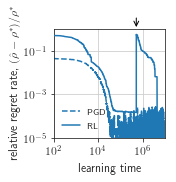

In [190]:
data_store=np.load(data_dir+'data_store_forage_beta_var.npy').item()

fig_rel,ax_rel=pl.subplots(figsize=(2,2))
mkrstr=['.','-']
subsample=np.concatenate((np.arange(100),99+np.logspace(0,np.log10(data_store['num_trials']-100),1e4,dtype=int)))

#just pull out 1 realization
for sit,seed in enumerate([seed_vec[0]]):
    bet_col=['C'+str(it) for it in range(len(data_store['betavec']))]
    for bit,beta in enumerate([data_store['betavec'][0]]):
        num_states=data_store['num_states']
        
        rho_opt=data_store[sit][bit]['rho_opt']

        for tit,type_str in enumerate(['PGD_data','TD_data']):

            times=data_store[sit][bit]['PGD_data']['times'][subsample]
            rho_est=data_store[sit][bit][type_str]['Qest'][subsample]
            if tit==0:
                ax_rel.plot(times,np.abs((rho_opt-rho_est)/rho_opt),bet_col[bit]+mkrstr[tit-1]+'-',ms=1,label='PGD')
            else:
                ax_rel.plot(times,np.abs((rho_opt-rho_est)/rho_opt),bet_col[bit]+mkrstr[tit],zorder=4,label='RL')

ax_rel.legend(frameon=False,prop={'size':9},loc=3)
ax_rel.annotate("",xy=(5e5,1),xytext=(5e5,4),xycoords='data',annotation_clip=True,arrowprops=dict(arrowstyle="->",color='k'))
ax_rel.set_yscale('log')
ax_rel.set_xscale('log')
ax_rel.set_xlim(1e2,1e7)
ax_rel.set_ylim(1e-5,1e0)
ax_rel.set_xlabel('learning time')
ax_rel.set_ylabel(r'relative regret rate, $(\hat{\rho}-\rho^*)/\rho^*$')
fig_rel.savefig(fig_dir+'PGD_TD_beta.pdf', transparent=True,bbox_inches="tight",dpi=300)

plot over realizations and parameter values

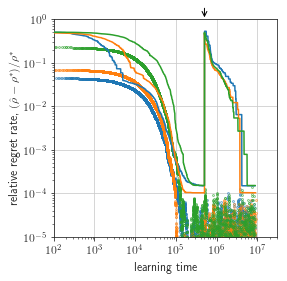

In [165]:
fig_rel,ax_rel=pl.subplots(figsize=(4,4))
mkrstr=['.','-']
subsample=np.concatenate((np.arange(100),99+np.logspace(0,np.log10(data_store['num_trials']-100),1e4,dtype=int)))
for sit,seed in enumerate([seed_vec[0]]):
    bet_col=['C'+str(it) for it in range(len(data_store['num_statevec']))]
    for bit,beta in enumerate(data_store['num_statevec']):
        beta=data_store['beta']
        rho_opt=data_store[sit][bit]['rho_opt']
        for tit,type_str in enumerate(['PGD_data','TD_data']):
            times=data_store[sit][bit]['PGD_data']['times'][subsample]
            rho_est=data_store[sit][bit][type_str]['Qest'][subsample]
            if tit==0:
                ax_rel.plot(times,np.abs((rho_opt-rho_est)/rho_opt),bet_col[bit]+mkrstr[tit],ms=1)
            else:
                ax_rel.plot(times,np.abs((rho_opt-rho_est)/rho_opt),bet_col[bit]+mkrstr[tit],zorder=4)

ax_rel.annotate("",xy=(5e5,1),xytext=(5e5,2),xycoords='data',annotation_clip=True,arrowprops=dict(arrowstyle="->",color='k'))
ax_rel.set_yscale('log')
ax_rel.set_xscale('log')
ax_rel.set_xlim(1e2,3e7)
ax_rel.set_ylim(1e-5,1e0)
ax_rel.set_xlabel('learning time')
ax_rel.set_ylabel(r'relative regret rate, $(\hat{\rho}-\rho^*)/\rho^*$')
fig_rel.savefig(fig_dir+'PGD_TD_states.pdf', transparent=True,bbox_inches="tight",dpi=300)

Text(0, 0.5, 'relative regret rate, $(\\hat{\\rho}-\\rho^*)/\\rho^*$')

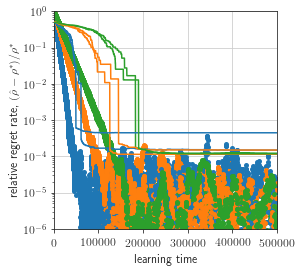

In [62]:
data_store=np.load(data_dir+'data_store_forage_statedim_var.npy').item()

fig_rel,ax_rel=pl.subplots(figsize=(4,4))
mkrstr=['.','-']
subsample=np.concatenate((np.arange(100),99+np.logspace(0,np.log10(data_store['num_trials']-100),1e4,dtype=int)))
for sit,seed in enumerate(seed_vec):
    bet_col=['C'+str(it) for it in range(len(data_store['betavec']))]
    for bit,beta in enumerate(data_store['betavec']):
        num_states=data_store['num_states']
        
        rho_opt=data_store[sit][bit]['rho_opt']

        for tit,type_str in enumerate(['PGD_data','TD_data']):
            times=data_store[sit][bit]['PGD_data']['times'][subsample]
            rho_est=data_store[sit][bit][type_str]['Qest'][subsample]
            if tit==0:
                ax_rel.plot(times,np.abs((rho_opt-rho_est)/rho_opt),bet_col[bit]+mkrstr[tit])
            else:
                ax_rel.plot(times,np.abs((rho_opt-rho_est)/rho_opt),bet_col[bit]+mkrstr[tit],zorder=4)
ax_rel.set_yscale('log')
ax_rel.set_xscale('log')
ax_rel.set_xlim(1,5e5)
ax_rel.set_ylim(1e-6,1e0)
ax_rel.set_xlabel('learning time')
ax_rel.set_ylabel(r'relative regret rate, $(\hat{\rho}-\rho^*)/\rho^*$')
# fig_rel.savefig('PGD_TD_states.pdf', transparent=True,bbox_inches="tight",dpi=300)